In [1]:
import pandas as pd
import numpy as np
import sys

sys.path.append('/its/home/skw24/python_modules')
import converter

dire = '/its/home/skw24/depmap/'
import re
import sl
import functools
import json
import random
import os
import math

import matplotlib.pyplot as plt

Import mutations from cell lines from Cosmic (CosmicCLP_MutantExport.tsv) and point mut_path at it
https://cancer.sanger.ac.uk/cosmic/download

Import gene expressions from cell lines from Cancer Cell Line Encyclopaedia (CCLE_RNAseq_genes_rpkm_20180929.gct)and point gene_path at it
https://portals.broadinstitute.org/ccle

Download cancer gene census https://cancer.sanger.ac.uk/census and point cgc_path at it. Use the separate jupyter notebook oncs,tsgs and kinases to form the three lists and save them.

A conversion dataframe must then be created from ensembl Grch37 - the mutations in cancer cell line encyclopaedia use 37 - though COSMIC uses 38. Details on how to do this are given in Converter.ipynb The path to the pandas dataframe should be called conv_path



In [ ]:
#mut_path = '/its/home/skw24/Data/CosmicCLP_MutantExport.tsv'

mut_path = '/its/home/skw24/Data/CCLE_DepMap_18q3_maf_20180718.txt' #replace with your own path
gene_path = '/its/home/skw24/Data/CCLE_RNAseq_genes_rpkm_20180929.gct' #replace with your own path
data_path = '/its/home/skw24/Data/'#replace with your own path. This should be where you saved the tsgs,oncs and kinases.
conv_path = '/its/home/skw24/Converter/gene_multi_converter.csv'#replace with your own path

load the databases and lists of genes

In [ ]:
conv = pd.read_csv(conv_path, header = 0, index_col = 0)

In [ ]:
cl = pd.read_csv('/its/home/skw24/depmap/all_weights.csv',header = 0,index_col = 0)
cell_lines = cl.columns

In [ ]:
mut_df0 = pd.read_csv(mut_path,header = 0, index_col = 0,sep = '\t')

exp_df  =pd.read_csv(gene_path,skiprows = 2,sep = '\t')

In [ ]:
def load_list(i):
    with open(os.path.join(data_path,'{}.json'.format(i))) as f:
        g = json.load(f)
    return g

kinases = load_list('kinases')
oncs = load_list('oncs')
tsgs =load_list('tsgs')

Identify the cell lines of interest and set these to cell_lines. Here we are using those previously defined, but they can
be any of the headers of exp_df that are also in mut_df0

In [ ]:
cl = pd.read_csv('/its/home/skw24/depmap/all_weights.csv',header = 0,index_col = 0)
cell_lines = cl.columns

# Identifying loss of function mutations

We split the mutations into two groups - those which will probably cause loss of function through nonsense or frameshift 
and those which are missense - others such as silent we discard

In [ ]:
mut_df = mut_df0.loc[mut_df0['Tumor_Sample_Barcode'].map(lambda x: x in cell_lines)]

In [ ]:
mut_df['Annotation_Transcript']=mut_df['Annotation_Transcript'].map(lambda x:x.split('.')[0])

In [ ]:
#first we separate out the badly pathogenic mutations - these are assumed to result in loss of function

pathogenic = ['Frame_Shift_Del', 'Frame_Shift_Ins','Nonsense_Mutation','Nonstop_Mutation','Stop_Codon_Del']

mut_df.index = mut_df.index.map(lambda x: x.split('_')[0])

path_muts = mut_df.loc[mut_df['Variant_Classification'].map(lambda x: x in pathogenic)]

path_muts_per_sample = pd.Series(path_muts.groupby('Tumor_Sample_Barcode').groups).map(lambda x:','.join(list(x)))

In [ ]:
tran_gene = conv['Gene stable ID']
tran_gene.index = conv['Transcript stable ID']
tran_gene = tran_gene.to_dict()

In [ ]:
path_muts['ENSGs']=path_muts['Annotation_Transcript'].map(lambda x: tran_gene.get(x,np.nan))

In [ ]:
path_muts1 = path_muts.loc[path_muts['ENSGs'].notnull()]

In [ ]:
path_muts1.index = range(path_muts1.shape[0])

In [ ]:
path_muts_per_sample = pd.Series(
    path_muts1.groupby(by = 'Tumor_Sample_Barcode').groups).map(
    lambda x: ','.join(list(set(path_muts1.reindex(x)['ENSGs']))))

In [ ]:
path_muts_per_sample.to_csv('path_muts_per_sample_new_cells.csv')

There are 582 loss of function mutations in total caused by frameshift or nonsense.
We then identify the missense mutations which are predicted by SIFT to cause pathogenic response.



In [ ]:
mut_df1_sm = mut_df.loc[mut_df['Variant_Classification']=='Missense_Mutation']

In [ ]:
print(mut_df1_sm.shape)

In [ ]:
ensts = pd.Series(list(set(mut_df1_sm['Annotation_Transcript'])))

In [ ]:
#accept ensts if they are included in out ensembl database conv with protein ids
transcript_stable_ids = set(conv['Transcript stable ID'])
ensts_with_ensps = ensts[ensts.map(lambda i: i in transcript_stable_ids)]

In [ ]:
def get_info(row):
    '''using the ready made conv, identify for each mutation the following
    ['Fasta',  'UniProtKB/Swiss-Prot ID',
       'Protein stable ID', 'transcript stable id', 'chromo', 'start', 'end',
       'wild', 'mutant']
    Throw away any rows which dont have this information as it will not be possible to find the missense status
       '''
    
    code = re.compile('p.([A-Z])(\d+)([A-Z])')
    def check(x,w,pos):
        '''helper function used below to check that our fasta has the right amino acid at the right place'''
        if len(x)>=pos:
            return x[pos-1]==w
        else:
            return False
    
    
    columns = ['Fasta','Protein stable ID', 'Transcript stable ID','UniProtKB/Swiss-Prot ID']
     
    enst,aa = row[['Annotation_Transcript','Protein_Change']]
    if enst in transcript_stable_ids:
        info = conv.loc[conv['Transcript stable ID']==enst][columns].drop_duplicates(subset = 'UniProtKB/Swiss-Prot ID')

    else:
        info = np.nan

    if type(info)==pd.DataFrame and info.shape[0]>0:
        match = code.match(aa)
        if match:
            w = match.group(1)
            pos = int(match.group(2))
            m = match.group(3)
        else:
            w,pos,m = np.nan,np.nan,np.nan

        info0 = info.loc[info['Fasta'].map(lambda x:check(x,w,pos))]
        if info0.shape[0]>0:
            info1 = info0.iloc[0]
        else:
            info1 = np.nan
    else:
        info1 = np.nan
        
    if type(info1)==pd.Series:
        info1['transcript stable id']=enst
        info1['wild'],info1['mutant'],info1['pos'] = w,m,pos
    return info1
        

info = mut_df1_sm.apply(get_info,axis = 1)

In [ ]:
info.shape

In [ ]:
def check_wild(row):
    try:
        f,w,p =row[['Fasta','wild','pos']]
        w0 = f[(int(p)-1)]
        return True
    except ValueError:
        return False

In [ ]:
check = info.apply(check_wild,axis=1)

In [ ]:
check.value_counts()

There are 20094 mutations and of these 1099 of them have missing fastas

In [ ]:
#include all of our extra information to our database
df2_sm =pd.concat([mut_df1_sm,info],axis=1)

df2_sm.index = range(df2_sm.shape[0])

# Find the String for use with sift

In [ ]:
def sift_string(row):
    c,s,strand,r,t = row[['Chromosome','Start_position','Strand','Reference_Allele','Tumor_Seq_Allele1']]
    conv_strand={'+':1,'-':-1}
    return "{},{},{},{}/{}".format(c,s,conv_strand[strand],r,t)

sift = df2_sm.apply(lambda row:sift_string(row),axis=1)

df2_sm['sift_string'] = sift

In [ ]:
sift_groups = pd.Series(df2_sm.groupby(by = 'sift_string' ).groups).map(lambda x: '_'.join(x.astype(str)))

sift_info = sift_groups.index+','+sift_groups

#all of our sift information is on the positive strand - I assume that this is the way CCLE count their mutations
pd.Series(sift_info).map(lambda x:x.split(',')[2]).value_counts()



string_nums = [str(i) for i in range(1,23)]
sift_info ='\n'.join([i for i in sift_info if i.split(',')[0] in string_nums])

with open('sift_info_new_cell_lines','w') as f:
    f.write(sift_info)

In [ ]:
with open('sift_info_new_cell_lines','r') as f:
    sift_info = f.read()

# Using the online tool sift 

The document created and saved above can now be used to feed into sift
https://sift.bii.a-star.edu.sg/www/Extended_SIFT_chr_coords_submit.html
The results were saved into sift_results_path and then analyzed

In [ ]:
dire = '/its/home/skw24/depmap/sift'
paths = os.listdir(dire)

In [ ]:
def load_sift(path):
    with open(path) as f:
        the_list = f.read().split('\n')
    the_array = [i.split('\t') for i in the_list]
    prob_length = len(the_array[len(the_array)//2])
    
    the_array0 = [i for i in the_array if len(i)==prob_length]

    ans= pd.DataFrame(the_array0[1:],columns = the_array0[0])
    ans.index = ans['Coordinates']
    return ans

In [ ]:
g = pd.concat([load_sift(os.path.join(dire,path)) for path in paths])

In [ ]:
g_damaging = g.loc[g['Prediction']=='DAMAGING']

In [ ]:
g_dict =g['Prediction'].to_dict()

In [ ]:
df2_sm['sift_results'] = df2_sm['sift_string'].map(lambda x: g_dict.get(x,np.nan))

In [ ]:
df3_sm = df2_sm.loc[df2_sm['sift_results']=='DAMAGING']

In [ ]:
df3_sm.head()

In [ ]:
df3_sm[['Tumor_Sample_Barcode','Protein stable ID']]

We assume that pathogenic mutations known tumor suppressors are loss of function
that pathogenic mutations in known oncogenes are gain of function and that any remaining pathogenic mutations 
in kinases are oncogenic.

Details on how to construct the three lists oncs,tsgs,kinases is given in the separate jupyter notebook oncs,tsgs,kinases

In [ ]:
onc_stable_ID = set(conv.loc[conv['Gene name'].map(lambda x:x in oncs)]['Protein stable ID'])

tsgs_stable_ID = set(conv.loc[conv['Gene name'].map(lambda x:x in set(tsgs))]['Protein stable ID'])

kinase_protein_stable_ID = set(conv.loc[conv['Gene name'].map(lambda x:x in kinases)]['Protein stable ID'])

def lof_gof(x):
    
    if x in tsgs_stable_ID:
        return 'lof'
    elif x in onc_stable_ID:
        return 'gof'
    elif x in kinase_protein_stable_ID:
        return 'gof'
    else:
        return 'lof'

In [ ]:
df3_sm['lof_gof'] = df3_sm['Protein stable ID'].map(lof_gof)

In [ ]:
def get_gene(x):
    gn = conv.loc[conv['Transcript stable ID']==x]['Gene stable ID']
    try:
        return gn.iloc[0]
    except IndexError:
        return np.nan

In [ ]:
enst_ensg = pd.Series(conv['Gene stable ID'],index = conv['Transcript stable ID']).to_dict()

In [ ]:
df3_sm['Gene']=df3_sm['Annotation_Transcript'].map(lambda x:enst_ensg.get(x,np.nan))

In [ ]:
gof = df3_sm.loc[df3_sm['lof_gof']=='gof']
lof = df3_sm.loc[df3_sm['lof_gof']=='lof']

In [ ]:
lists_of_genes = lambda df:pd.Series(df.groupby(by = 'Tumor_Sample_Barcode').groups).map(
    lambda x: ','.join(set(df.reindex(x)['Gene'].values)-set([np.nan])))

cell_gofs = lists_of_genes(gof)
cell_lofs_missense = lists_of_genes(lof)

In [ ]:
index = list(set(path_muts_per_sample.index)|set(cell_lofs_missense.index))

path_muts_per_sample=path_muts_per_sample.reindex(index).fillna('')
cell_lofs_missense=cell_lofs_missense.reindex(index).fillna('')

cell_lofs = (path_muts_per_sample+cell_lofs_missense).map(lambda x: ','.join(set(x.split(','))))

In [ ]:
cell_lofs.to_csv('cell_lofs.csv')
cell_gofs.to_csv('cell_gofs.csv')

In [ ]:
class Gene:
    
    ''''''
    
    conv0 = converter.multi_converter
    all_genes = list(set(conv0.loc[conv0['Protein stable ID']!='']['Gene stable ID']))
    all_genes.sort()
    name_ensg = conv['Gene stable ID']
    name_ensg.index = conv['Gene name']
    name_ensg = name_ensg.to_dict()
    cell_lofs = pd.read_csv('cell_lofs.csv',squeeze = True,header = None,index_col = 0)
    cell_gofs = pd.read_csv('cell_gofs.csv',squeeze = True,header = None,index_col = 0)
    
    def rpkm():
        
        if '_rpkm' not in Gene.__dict__:
            
            temp = pd.read_csv(gene_path,skiprows = 2,sep = '\t')
            temp.index = temp['Name'].map(lambda x: x.split('.')[0])
            temp = temp.loc[Gene.all_genes]
            temp.drop(labels = ['Name','Description'],axis = 'columns',inplace = True)
            Gene._rpkm = temp            
        return Gene._rpkm
        
       

    
    
    def __init__(self,cell_lines = []):
        
        if len(cell_lines)==0:
            with open('{}good_cell_lines.json'.format(self.directory)) as f:
                self.cell_lines=json.load(f)
        else:
            self.cell_lines = cell_lines
                    
        self.rpkm = Gene.rpkm()[self.cell_lines]
        #self.rpkm.to_csv('/its/home/skw24/depmap/apollo/{}/rpkm.csv'.format(cancer))
        
        # we are going to assume that every gain of function bumps the effective
        #gene expression to 10 times what it would otherwise have been.
        
        self.gain_of_function =  self.convert_lists_to_binary_df(Gene.cell_gofs)*9+1
        self.loss_of_function =  self.convert_lists_to_binary_df(Gene.cell_lofs)
        
        self.temp = Gene.rpkm().T.copy()
        #separate the cell lines by tissue type
        self.temp['tissue_type'] = self.temp.index.map(lambda x:x.split('_')[-1])
        #for each tissue type take the average of the rpkms
        self.means = self.temp.groupby(by = 'tissue_type',axis = 0).mean()
        self.tissue_type = self.temp['tissue_type']
        self.temp = self.temp.drop(labels = ['tissue_type'],axis=1)
        #find the ratio of the actual value to the average tissue type value
        means = pd.DataFrame(list(self.tissue_type.map(lambda x: self.means.loc[x])),index = self.tissue_type.index)
        self.prop_tt = ((self.temp/means).fillna(100).T)[self.cell_lines]
        
        all_means= Gene.rpkm()[Gene.rpkm().columns[2:]].fillna(0).T.mean()
        self.prop_all = self.rpkm.apply(lambda row: row/all_means.loc[row.name],axis = 1)
        

    def convert_lists_to_binary_df(self,series):
        '''given a series of lists of genes we put them into the same format as self.rpkm, filling
        any nans with 0s and ensuring that everything is an integer'''

        # first we turn our string into a list, assign ones to anything in the list and bulk it up to 
        #the same index as self.rpkm
        convert_to_ones = lambda x:pd.Series(1,index = x.split(',')).reindex(self.rpkm.index)

        #now we convert that series into a data frame
        ones = pd.DataFrame(list(series.map(convert_to_ones)),index = series.index).T

        #finally we bulk up the columns to match self.rpkm, fill in any nans with 0s and turn it back into 
        #and integer df
        return ones.reindex(self.rpkm.columns,axis = 1).fillna(0).astype(int)
        
    def get_weights(self,scale):
        
        return {
            'raw':self.scaling(self.rpkm,scale),
            'mean_for_tissue_type':self.scaling(self.prop_tt,scale),
            'mean_for_all':self.scaling(self.prop_all,scale)
        }      
    
    def get_raw_weights(self,tanh_parameter):
        return self.scaling(self.rpkm,'tanh',tanh_parameter)
    
    def get_tt_weights(self,tanh_parameter):
        return self.scaling(self.prop_tt,'tanh',tanh_parameter)
    
    def get_all_weights(self,tanh_parameter):
        return self.scaling(self.prop_all,'tanh',tanh_parameter)
        
    def scaling(self,df,scale,tanh_parameter):
        

        df1=df*self.gain_of_function
        df2 = df1.fillna(0)
        scale_functions = {'tanh':lambda x: 0.5-0.5*(math.tanh(tanh_parameter+math.log(x+1e-10))),
                                   'inverse': lambda x:max(int(1/(x+1e-4)),1)
                                  }
        scalar={'tanh':1,'inverse':10000}
        df3= df2.applymap(scale_functions[scale])
        mx = np.vectorize(max)


        columns = df.columns
        index = df.index


        w= pd.DataFrame(mx(df3,self.loss_of_function*scalar[scale]),
                                      index = index,columns= columns)


        w=w.reindex(Gene.all_genes).fillna(1)

        return w
       

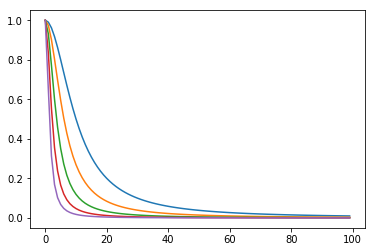

In [2]:
tanh = np.vectorize(lambda x,a=0: 0.5-0.5*(math.tanh(a+math.log(x+1e-10))))

myrange = np.arange(0,10,0.1)

for a in range(5):
    plt.plot(tanh(myrange,a/2))

In [ ]:
globals().keys()

In [ ]:
self = Gene(cell_lines)

In [ ]:
#Trying out a number of different parameters for our smoothing function. You can see from above what type 
#of difference they make
weights = []
for a in range(5):
    tanh_parameter = a/2
    w=self.get_raw_weights(tanh_parameter)
    w.to_csv('raw_weights_with_tanh_{}.csv'.format(a))
    weights.append(w)
    print(a)

In [ ]:
df = self.prop_tt.T
for a in range(5):
    tanh_parameter = a/2
    w=self.get_tt_weights(tanh_parameter)
    w.to_csv('tt_weights_with_tanh_{}.csv'.format(a))
    print(a)

In [ ]:
for a in range(5):
    tanh_parameter = a/2
    w=self.get_all_weights(tanh_parameter)
    w.to_csv('all_weights_with_tanh_{}.csv'.format(a))
    print(a, end = '')